In [19]:
import matplotlib.pyplot as plt
plt.rc('font', size=12)
import pandas as pd
import seaborn as sns
import warnings 

import Coverage as cov

warnings.filterwarnings('ignore')
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Params

In [2]:
#get list of client rules sorted by count
popSize = 10
clientFilename = "../Data/ICU/Best/"
# clientFilename = "../Data/ICU/Test/"
# clientFilename = "../Data/Sepsis/Best/"

ldpFilename = "../Results/ICU_Base_TEST.csv"
# ldpFilename = "../Results/ICU_Ruleset_MCTS_TEST.csv"
# ldpFilename = "../Results/ICU_TEST_2.csv"
# ldpFilename = "../Results/Sepsis_Ruleset_MCTS_Test.csv"

graphName = '../Results/Graphs/test' #Name of count coverage graphs
popThresh = 0.01 #Percentage match count


## Load Client Rules

In [3]:
# Load Client Rule Trees and Text Rule Structures, and get dataframe of rules and their counts
clientTrees, clientRules, clientDF = cov.loadClientRules(popSize, clientFilename)
clientDF

File not found for Client 8


,Rule,Rule Count,Percent of Population
53,"((MET >= 0.000) U[0,0] (death = 0.000))",17,1.0
56,"F[0,0]((BLOOD_UREA_NITROGEN <= 0.000 & CREATIN...",13,1.0
57,"G[0,0]((n_evts <= 0.000 -> LOS >= 0.000))",12,1.0
47,"G[0,0]((hr >= 0.000 & Pulse >= 0.000))",3,0.3
172,"((af >= 0.000) U[0,0] (direct >= 0.000))",3,0.3
...,...,...,...
188,"F[0,0]((HEMOGLOBIN <= 0.000 & O2_Flow <= 0.000))",1,0.1
187,"F[0,0]((dfa >= 0.000 & Mort >= 0.000))",1,0.1
186,"((O2_Flow <= 0.000) U[0,0] (PLATELET_COUNT >= ...",1,0.1
185,"((MET >= 0.000) U[0,0] (PARTIAL_THROMBOPLASTIN...",1,0.1


In [10]:
clientDF.to_csv("Client Rules.csv")

## Load LDP Ruleset

In [4]:
ldpDF, ldpTrees, ldpRules = cov.loadLDPRuleset(ldpFilename)
ldpDF

,Rule,Percent Count
418,"F[0,0]((y = 0.000 -> y = 0.000))",0.700
3729,"G[0,0]((n_evts < 0.000 -> LOS > 0.000))",0.444
748,"G[0,0]((LOS > 0.000 -> n_evts = 0.000))",0.444
696,"G[0,0]((n_evts = 0.000 -> LOS > 0.000))",0.444
3045,"G[0,0]((y = 0.000 -> y = 0.000))",0.444
...,...,...
1727,"((hr > 0.000) U[0,0] (Glasgow_Coma_Scale_Total...",0.100
1728,"F[0,0]((POTASSIUM > 0.000 -> Mort = 0.000))",0.100
1730,"((n_evts = 0.000) U[0,0] (direct = 0.000))",0.100
1732,"((n_evts = 0.000) U[0,0] (dfa = 0.000))",0.100


## Complexity Analysis

In [5]:
k = 4 #k-ary tree
h = 17 #height
k**h

17179869184

## Get Table of Structure Counts - Count of rules above threshold

In [6]:
covDF, countDF, clientTrees = cov.getCoverageTable(popThresh, ldpDF, ldpTrees, clientDF)
countDF.to_csv(ldpFilename + "_CovCountDF.csv")
covDF

RULE NOT FOUND F[0,0]((cosen > 0.000 & O2_Flow = 0.000))
RULE NOT FOUND F[0,0]((CREATININE = 0.000 & BLOOD_UREA_NITROGEN > 0.000))
RULE NOT FOUND F[0,0]((tte > 0.000 & WHITE_BLOOD_CELL_COUNT = 0.000))
RULE NOT FOUND F[0,0]((Glasgow_Coma_Scale_Total = 0.000 & s24_hr < 0.000))
RULE NOT FOUND F[0,0]((n_edrk = 0.000 & tte < 0.000))
RULE NOT FOUND F[0,0]((af = 0.000 & O2_Flow < 0.000))
RULE NOT FOUND F[0,0]((LACTIC_ACID = 0.000 & PHOSPHORUS > 0.000))
RULE NOT FOUND F[0,0]((BLOOD_UREA_NITROGEN < 0.000 & WHITE_BLOOD_CELL_COUNT = 0.000))
RULE NOT FOUND F[0,0]((s24_hr = 0.000 & Glasgow_Coma_Scale_Total > 0.000))
RULE NOT FOUND F[0,0]((O2_Flow < 0.000 & cosen > 0.000))
RULE NOT FOUND F[0,0]((O2_Flow > 0.000 & PLATELET_COUNT < 0.000))
RULE NOT FOUND F[0,0]((Glasgow_Coma_Scale_Total > 0.000 & BLOOD_UREA_NITROGEN < 0.000))
RULE NOT FOUND F[0,0]((lds = 0.000 & PLATELET_COUNT > 0.000))
RULE NOT FOUND F[0,0]((O2_Flow < 0.000 & cosen = 0.000))
RULE NOT FOUND F[0,0]((Glasgow_Coma_Scale_Total > 0.000 & n

,Total Client Rules,Found Rules,Non Rules,Precision
0,553,3790,110,0.971795


In [7]:
countDF

,LDP Rule,Client Rule,LDP Count,Client Count
0,"((Glasgow_Coma_Scale_Total = 0.000) U[0,0] (s8...","((Glasgow_Coma_Scale_Total >= 0.000) U[0,0] (s...",0.100,0.1
1,"G[0,0]((ICU_Pt_Days = 0.000 -> y < 0.000))","G[0,0]((ICU_Pt_Days >= 0.000 -> y <= 0.000))",0.111,0.1
2,"G[0,0]((s8_hr < 0.000 -> SBP < 0.000))","G[0,0]((s8_hr <= 0.000 -> SBP <= 0.000))",0.111,0.1
3,"((lds = 0.000) U[0,0] (LOS > 0.000))","((lds >= 0.000) U[0,0] (LOS >= 0.000))",0.100,0.1
4,"((direct > 0.000) U[0,0] (n_edrk > 0.000))","((direct >= 0.000) U[0,0] (n_edrk >= 0.000))",0.100,0.1
...,...,...,...,...
3785,"F[0,0]((y = 0.000 -> ICU_Pt_Days > 0.000))","F[0,0]((ICU_Pt_Days >= 0.000 -> y >= 0.000))",0.100,0.1
3786,"((MET = 0.000) U[0,0] (s8_edrk = 0.000))","((MET >= 0.000) U[0,0] (s8_edrk <= 0.000))",0.100,0.1
3787,"G[0,0]((y < 0.000 -> AF = 0.000))","G[0,0]((AF >= 0.000 -> y <= 0.000))",0.111,0.1
3788,"((ICU_Pt_Days > 0.000) U[0,0] (WHITE_BLOOD_CEL...","((ICU_Pt_Days >= 0.000) U[0,0] (WHITE_BLOOD_CE...",0.100,0.1


## Get number of unique structure types

In [8]:
structDF = cov.countUniqueStructuresNoVars(clientTrees, ldpTrees)
structDF

CLIENT STRUCT NOT FOUND F[0,0](((x <= 0.000 | x <= 0.000) & x >= 0.000))


,Total Client Structures,Found Structures,Non Structures,Precision
0,43,42,0,1.0


## Compare LDP Rules Found vs the Percent Client Counts 

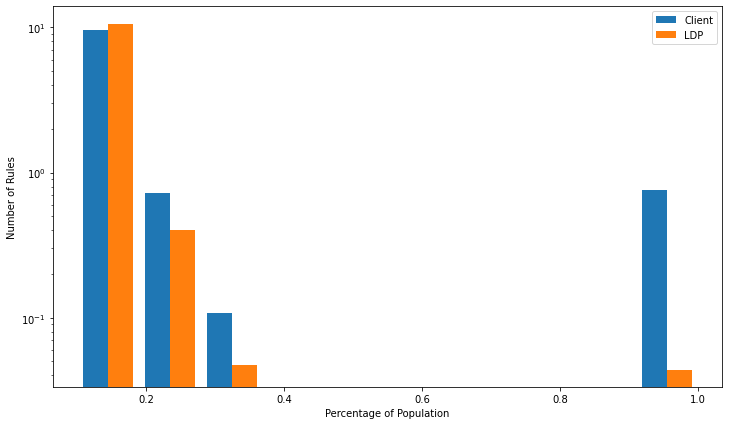

In [9]:
#make list of rule counts x population percents

lst = []
for idx, row in clientDF.iterrows():
    lst.extend([row['Percent of Population'] for i in range(row['Rule Count'])])
    
n_bins = 10

plt.figure(figsize=(12, 7))
plt.hist([lst, countDF['Client Count'].values], n_bins, density=True, histtype='bar',label=['Client', 'LDP'])
plt.xlabel("Percentage of Population")
plt.ylabel("Number of Rules")
plt.yscale('log')
plt.legend()


In [46]:
from SignalTemporalLogic.STLFactory import STLFactory
from Client import Client
from Server import Server

In [59]:
# From client rules, first make client trees
clientRules = ['F[0,0]((death <= 0.000 & y >= 0.000))']
clientTrees = []
stlFac = STLFactory()

for c in clientRules:
    c = stlFac.constructFormulaTree(c + "\n")
    clientTrees.append(c)
    
clientTrees

In [60]:
ldpRules = ['F[0,0](death > 0.000 & y = 0.000)']
ldpTrees = []
stlFac = STLFactory()

for c in ldpRules:
    c = stlFac.constructFormulaTree(c + "\n")
    ldpTrees.append(c)
    
ldpTrees

In [63]:
def queryStructuralFullMatch(template, clientTrees):

    client = Client(clientNum=1, epsilon='inf', ruleSet=clientTrees)
    server = Server(clientList=[], varDict={}, params=None)

#     print("Temp vars", varList)
#     print("\ntemp", template.toString())
    ldpNodes = server.getTemplateNodes(template)
    ldpVars = template.getAllVars()

#     print("templt nodes", ldpNodes)

    r = client.queryStructuralRuleMatchReturn(ldpNodes, ldpVars)

    return r

In [65]:
found = queryStructuralFullMatch(ldpTrees[0], clientTrees)
print(found)

None


In [66]:
def nodeListMatch(tempList, cList):
    relops = ['GT', 'GE', 'LT', 'LE', "EQ"]  # , 'NEQ']

    i = 0
    while i < len(tempList):
        # get current branch of nodes
        if tempList[i] in cList:
            if 'Parameter' not in tempList[i]:  # found a var match
                #                 idx = cList.index(tempList[i])  # get idx of element of cList
                #                 cList = cList[idx + 1:]
                cList.remove(tempList[i])

        elif any(item in tempList[i] for item in relops):
            # Try all match options
            if 'GT' in tempList[i]:
                test = [x if x != "GT" else "GE" for x in tempList[i]]

                if test in cList:
                    cList.remove(test)
                else:
                    return False
            elif 'GE' in tempList[i]:
                test1 = [x if x != "GE" else "GT" for x in tempList[i]]
                test2 = [x if x != "GE" else "EQ" for x in tempList[i]]

                try:
                    idx1 = cList.index(test1)
                except:
                    idx1 = 999999999
                try:
                    idx2 = cList.index(test2)
                except:
                    idx2 = 999999999

                if test1 in cList and (idx1 < idx2):
                    cList.remove(test1)
                elif test2 in cList and (idx2 < idx1):
                    cList.remove(test2)
                else:
                    return False
            elif 'LT' in tempList[i]:
                test = [x if x != "LT" else "LE" for x in tempList[i]]
                if test in cList:
                    cList.remove(test)
                else:
                    return False
            elif 'LE' in tempList[i]:
                test1 = [x if x != "LE" else "LT" for x in tempList[i]]
                test2 = [x if x != "LE" else "EQ" for x in tempList[i]]
                try:
                    idx1 = cList.index(test1)
                except:
                    idx1 = 999999999
                try:
                    idx2 = cList.index(test2)
                except:
                    idx2 = 999999999

                if test1 in cList and (idx1 < idx2):
                    cList.remove(test1)
                elif test2 in cList and (idx2 < idx1):
                    cList.remove(test2)
                else:
                    return False
            elif 'EQ' in tempList[i]:
                test1 = [x if x != "EQ" else "GE" for x in tempList[i]]
                test2 = [x if x != "EQ" else "LE" for x in tempList[i]]

                try:
                    idx1 = cList.index(test1)
                except:
                    idx1 = 999999999
                try:
                    idx2 = cList.index(test2)
                except:
                    idx2 = 999999999

                if test1 in cList and (idx1 < idx2):
                    cList.remove(test1)
                elif test2 in cList and (idx2 < idx1):
                    cList.remove(test2)
                else:
                    return False

        else:
            return False

        i = i + 1

    return True

In [67]:
tempList = [['eval', 0], ['statementList', 1], ['statement', 2], ['boolExpr', 3], ['stlTerm', 4], ['BooleanAtomic', 'F', 5], ['boolExpr', 6], ['stlTerm', 7], ['BooleanAtomic', 8], ['boolExpr', 9], ['AND', 'stlTerm', 'stlTerm', 10], ['BooleanAtomic', 11], ['BooleanAtomic', 11], ['GE', 'ICU_Pt_Days', 'Parameter', 12], ['LE', 'n_edrk', 'Parameter', 12]]
cList = [['eval', 0], ['statementList', 1], ['statement', 2], ['boolExpr', 3], ['stlTerm', 4], ['BooleanAtomic', 'F', 5], ['boolExpr', 6], ['stlTerm', 7], ['BooleanAtomic', 8], ['boolExpr', 9], ['AND', 'stlTerm', 'stlTerm', 10], ['BooleanAtomic', 11], ['BooleanAtomic', 11], ['EQ', 'n_edrk', 'Parameter', 12], ['LT', 'ICU_Pt_Days', 'Parameter', 12]]
nodeListMatch(tempList, cList)


False

In [68]:
tempList = [['eval', 0], ['statementList', 1], ['statement', 2], ['boolExpr', 3], ['stlTerm', 4], ['BooleanAtomic', 'F', 5], ['boolExpr', 6], ['AND', 'stlTerm', 'stlTerm', 7], ['BooleanAtomic', 8], ['BooleanAtomic', 8], ['EQ', 'death', 'Parameter', 9], ['GT', 'y', 'Parameter', 9]]
cList = [['eval', 0], ['statementList', 1], ['statement', 2], ['boolExpr', 3], ['stlTerm', 4], ['BooleanAtomic', 'F', 5], ['boolExpr', 6], ['AND', 'stlTerm', 'stlTerm', 7], ['BooleanAtomic', 8], ['BooleanAtomic', 8], ['LE', 'death', 'Parameter', 9], ['GE', 'y', 'Parameter', 9]]

nodeListMatch(tempList, cList)


True

In [76]:
stlFac = STLFactory()
temp = stlFac.constructFormulaTree("F[?,?](y = ? & death > ?)\n")

server = Server(clientList=[], varDict={}, params=None)
server.getTemplateNodes(temp)

[['eval', 0],
 ['statementList', 1],
 ['statement', 2],
 ['boolExpr', 3],
 ['stlTerm', 4],
 ['BooleanAtomic', 'F', 5],
 ['boolExpr', 6],
 ['AND', 'stlTerm', 'stlTerm', 7],
 ['BooleanAtomic', 8],
 ['BooleanAtomic', 8],
 ['EQ', 'y', '?', 9],
 ['GT', 'death', '?', 9]]

In [77]:
stlFac.constructFormulaTree(temp.toStringWithParams())

AttributeError: 'STLTree' object has no attribute 'toStringWithParams'

In [75]:
getTemplateNodes(temp)

NameError: name 'self' is not defined